# Plant pathology 2020

# Setting up env and downloading dataset

In [2]:
import os
from pathlib import Path

def check_environment() -> bool:
    """Check if the notebook is running in Google Colab or not.

    Returns:
        bool: True if running in Colab, False otherwise.
    """
    return bool(os.getenv("COLAB_RELEASE_TAG"))

def download_utils(colab_flag):
  """Function to clone the required utils .py helper module if running in colab

  Returns:
    None
  """
  if colab_flag:
    !curl -o /content/setup_utils.py https://raw.githubusercontent.com/jalkestrup/fastai_course/main/10_final_project/setup_utils.py
  else:
    return


In [3]:
colab_flag = check_environment()
download_utils(colab_flag)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3017  100  3017    0     0  10248      0 --:--:-- --:--:-- --:--:-- 10261


In [4]:
#Helper functions for setting up the environment and downloading the dataset based on compute environment
from setup_utils import install_libraries, download_kaggle_data, set_kaggle_credentials

install_libraries(colab_flag)

set_kaggle_credentials(colab_flag)

kaggle_dataset = 'plant-pathology-2020-fgvc7'
download_kaggle_data(kaggle_dataset)

Running in Colab...
...Installed required dependencies
Mounted at /content/drive/
Sucesfully set kaggle credentials
Data not detected, starting download


100%|██████████| 779M/779M [00:23<00:00, 35.2MB/s]


# Inspecting the data

In [5]:
import timm
from fastai.vision.all import *

path = Path('plant-pathology-2020-fgvc7')

image_path = path/'images'
image_files = get_image_files(image_path)

Shape of image : (1365, 2048)


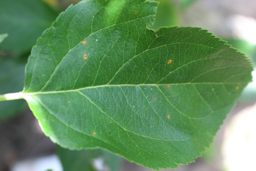

In [6]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

The images are of similar size (1365 x 2048), but a few are rotated (2048x1365). To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.



## Loading resized images
From previous script I have resized the images to 266x400 size, and saved them on Google Drive. We load these for experimentation

In [7]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

Number of cores 2


In [8]:
"""
dest = path/'small_images'
resize_images(path/'images', max_size=400, dest=dest, recurse=True)

#Save resized images to drive for fast reload in new instance
Copy images from path/small_images to /content/drive/MyDrive/dtu/fastAI/10_final_project
!cp -r '/content/plant-pathology-2020-fgvc7/small_images' /content/drive/MyDrive/dtu/fastAI/10_final_project
"""
#Copy prev resized images from drive to Colab
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
!mkdir /content/plant-pathology-2020-fgvc7/small_images
!cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/small_images/. '/content/plant-pathology-2020-fgvc7/small_images'

#Check the size of a photo in the small_images
image_path_small = path/'small_images'
image_files_small = get_image_files(image_path_small)
sizes = parallel(check_size, image_files_small, n_workers=n_cores)

pd.Series(sizes).value_counts()

(266, 400)    3642
dtype: int64

## Setting up labels

In [9]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [10]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [11]:
df_train.label.value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

# Model experimentation

In [12]:
#Function for collecting and emptying GPU Cache

!pip install pynvml
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

report_gpu()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
GPU:0
no processes are running


## Setting up W&B and model function

In [27]:
!pip install -Uq wandb
# Silence Wandb printouts
os.environ["WANDB_SILENT"] = "true"

import wandb

!wandb login

In [36]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
from fastai.callback.wandb import *

def train_model(arch, item, batch, epochs, batch_size=64, learning_rate=0.005, accum_steps=1):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  }

  wandb.init(project='apple_disease', entity='jealk', group='model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0, patience=3)
  callbacks = [WandbCallback(log=None,log_preds=False,log_model=False),early_stopping_cb]

  if accum_steps > 1:
    gradient_accumulation_cb = GradientAccumulation(accum_steps)
    callbacks.append(gradient_accumulation_cb)

  learn.fine_tune(epochs,learning_rate, cbs=callbacks)

  wandb.finish()
  return learn, dls

In [35]:
arch = 'vit_small_patch16_224.augreg_in21k_ft_in1k'

learn,dls = train_model(arch,
                        item=Resize(256, method='crop'),
                        batch=aug_transforms(size=224, min_scale=0.75),
                        epochs=15)


epoch,train_loss,valid_loss,error_rate,time
0,1.056146,0.552732,0.126374,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.417387,0.429497,0.098901,00:11
1,0.355464,0.309545,0.082418,00:09
2,0.310565,0.267302,0.063187,00:10
3,0.265930,0.260905,0.071429,00:12
4,0.225980,0.234721,0.060440,00:08
5,0.187980,0.230728,0.054945,00:13
6,0.157334,0.237112,0.043956,00:10
7,0.133741,0.233302,0.049451,00:10
8,0.112507,0.243064,0.054945,00:10
9,0.104724,0.227828,0.049451,00:09


No improvement since epoch 6: early stopping


# Testing predictions

In [37]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [38]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_test = pd.read_csv(f'{path}/test.csv')
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


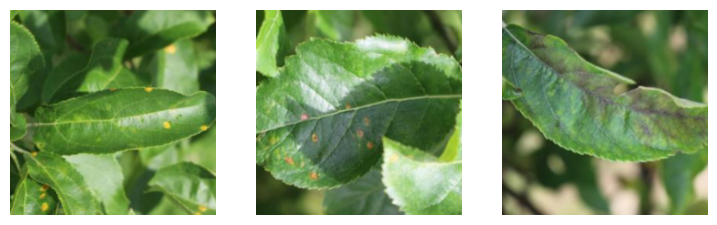

In [45]:
test_dl = dls.test_dl(df_test)
test_dl.show_batch(max_n=3)

In [58]:
preds,_ = learn.get_preds(dl=test_dl)

In [62]:
len(preds)

1821

In [46]:
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [65]:
p = preds.softmax(axis=1)
p

tensor([[0.1750, 0.1752, 0.4748, 0.1750],
        [0.1749, 0.1751, 0.4751, 0.1749],
        [0.1749, 0.1749, 0.1749, 0.4754],
        ...,
        [0.1750, 0.1752, 0.4748, 0.1750],
        [0.4753, 0.1749, 0.1749, 0.1749],
        [0.1749, 0.1749, 0.1749, 0.4753]])

In [68]:
df_preds = pd.DataFrame(preds)

In [70]:
df_preds.head()

,0,1,2,3
0,3.996303e-05,1.538165e-03,9.984219e-01,4.947038e-08
1,2.860112e-07,8.279715e-04,9.991716e-01,7.259798e-08
2,5.183252e-07,6.286805e-06,2.605524e-09,9.999932e-01
3,1.000000e+00,7.823256e-10,6.972793e-09,4.555041e-09
4,3.458996e-08,1.488362e-05,9.999851e-01,5.590946e-10


In [75]:
df_preds['preds_sum'] = df_preds.sum(axis=1)

In [77]:
df_preds.head()

,0,1,2,3,preds_sum
0,3.996303e-05,1.538165e-03,9.984219e-01,4.947038e-08,1.0
1,2.860112e-07,8.279715e-04,9.991716e-01,7.259798e-08,1.0
2,5.183252e-07,6.286805e-06,2.605524e-09,9.999932e-01,1.0
3,1.000000e+00,7.823256e-10,6.972793e-09,4.555041e-09,1.0
4,3.458996e-08,1.488362e-05,9.999851e-01,5.590946e-10,1.0
